In [1]:
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import random
from collections import deque, namedtuple 
import numpy as np
import matplotlib.pyplot as plt

In [28]:

class GridWorldEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self):
        super(GridWorldEnv, self).__init__()
        self.action_space = spaces.Discrete(4)  # Left, Right, Up, Down
        self.observation_space = spaces.Discrete(16)  # 4x4 grid world
        self.agent_pos = (3, 0)  # Starting position
        self.treasure_pos = (0, 0)  # Treasure position
        self.treasure_reward = 10.
        self.gamma = 0.9

    def step(self, action):
        (x, y) = self.agent_pos
        if action == 0:  # Left
            y = np.maximum(y - 1, 0)
        elif action == 1:  # Right
            y = np.minimum(y + 1, 3)
        elif action == 2:  # Up
            if not (x == 1 and y < 3):
                x = np.maximum(x - 1, 0)
        elif action == 3:  # Down
            if not (x == 0 and y < 3):
                x = np.minimum(x + 1, 3)
        
        self.agent_pos = (x, y)
        self.current_step += 1
        # Check if the agent found the treasure
        # done = (self.agent_pos == self.treasure_pos) | (self.current_step > self.max_len)
        done = self.agent_pos == self.treasure_pos
        reward = self.treasure_reward if done else 0

        return np.array(self.agent_pos), reward, done, {}

    def reset(self):
        self.current_step = 0
        self.agent_pos = (3, 0)  # Reset to starting position
        return np.array(self.agent_pos)

    def render(self, mode='human', close=False):
        grid = np.zeros((4, 4),dtype=str)
        # Represent the agent and treasure
        grid[self.agent_pos] = 'A'  
        grid[self.treasure_pos] = 'T'  
        print(grid)
        
def discounted_cumsum(x: np.ndarray, gamma: float) -> np.ndarray:
    cumsum = np.zeros_like(x)
    cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0] - 1)):
        cumsum[t] = x[t] + gamma * cumsum[t + 1]
    return cumsum

In [30]:
# Create and use the environment
ACTION = {0: "left",
          1: "right",
          2: "up",
          3: "down"}
env = GridWorldEnv()
obs = env.reset()
print(f"="*30)
for action in [0, 1, 2, 3]:
    obs, reward, done, info = env.step(action)
    env.render()
    print(f"action = {ACTION[action]}")
    print(f"Observation: {obs}, Reward: {reward}, Done: {done}")

[['T' '' '' '']
 ['' '' '' '']
 ['' '' '' '']
 ['A' '' '' '']]
action = left
Observation: [3 0], Reward: 0, Done: False
[['T' '' '' '']
 ['' '' '' '']
 ['' '' '' '']
 ['' 'A' '' '']]
action = right
Observation: [3 1], Reward: 0, Done: False
[['T' '' '' '']
 ['' '' '' '']
 ['' 'A' '' '']
 ['' '' '' '']]
action = up
Observation: [2 1], Reward: 0, Done: False
[['T' '' '' '']
 ['' '' '' '']
 ['' '' '' '']
 ['' 'A' '' '']]
action = down
Observation: [3 1], Reward: 0, Done: False


# Q2:

Implement the DQN algorithm (with experience replay and target network) with ϵ-greedy exploration, i.e. the agent use the action at =
arg maxa Qt(st) with probability 1−ϵ and at = Unif(A) with probability ϵ. You
are free to tune ϵ as well as other hyper-parameters in DQN as you wish. Use
a two-layer MLP for the Q-network.

In [32]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        state = torch.relu(self.fc1(state))
        return self.fc2(state)


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size, 
                 buffer_size, batch_size, update_every,
                 learning_rate, gamma, tau, device, use_duoble_dqn=False):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.tau = tau
        self.device = device
        self.update_steps = 0
        self.use_duoble_dqn = use_duoble_dqn

        self.q = QNetwork(state_size, action_size, hidden_size).to(device)
        self.q_targ = QNetwork(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.q.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size, batch_size)
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
    def train(self):
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)
        
        if (self.update_steps + 1) % self.update_every == 0:
            self.soft_update()

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.q.eval()
        with torch.no_grad():
            action_values = self.q(state)
        self.q.train()
 
        if random.random() > eps:
            return np.argmax(action_values.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        # print(states.shape, actions.shape)
        criterion = nn.MSELoss()
        self.optimizer.zero_grad()

        # Get expected Q values from local model
        Q_expected = self.q(states).gather(1, actions)

        # Get max predicted Q values (for next states) from target model
        if not self.use_duoble_dqn:
            Q_targets_next = self.q_targ(next_states).max(1)[0].unsqueeze(1)
        else:
            Q_local_max_actions = self.q(next_states).max(1)[1].unsqueeze(1)
            Q_targets_next = self.q_targ(next_states).gather(1, Q_local_max_actions)

        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))


        # Compute loss
        loss = criterion(Q_expected, Q_targets)
        loss.backward()
        self.optimizer.step()        
        self.update_steps += 1

    def soft_update(self):
        for target_param, local_param in zip(self.q_targ.parameters(), self.q.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

In [33]:
epochs = 100
steps_per_epoch = 20
save_every = 50
eval_every = 10
eval_rollout = 10
buffer_size = 10000
update_every = 100
max_len = 1000
batch_size = 128
state_size = 2
action_size = 4
hidden_size = 256
learning_rate = 1e-3
eps = 0.7
tau = 0.995
gamma = 0.9
device = "cpu"
seeds = [0, 11, 22, 33, 44, 55, 66, 77, 88, 99]
seed = seeds[0]

eps_start = 1.0    # starting value of epsilon
eps_end = 0.01     # minimum value of epsilon
eps_decay = 0.995  # multiplicative factor (per episode) for decreasing epsilon

eval_rew_list = []
for seed in seeds:
    random.seed(seed)
    torch.manual_seed(seed)

    # replaybuffer = ReplayBuffer(buffer_size, batch_size)
    agent = DQNAgent(state_size, action_size, hidden_size, 
                    buffer_size, batch_size, update_every,
                    learning_rate, gamma, tau, device)
    env = GridWorldEnv()

    # Training loop
    # eps = eps_start
    eps = 0.5
    eval_rew = []
    for i in range(epochs):
        state = env.reset()
        for t in range(max_len):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        # Decrease epsilon
        # eps = max(eps_end, eps_decay*eps)
        # eps = 0.5
        # eps = eps_start - (eps_start-eps_end)/total_steps * agent.update_steps
        
        for _ in range(steps_per_epoch):
            agent.train()
        
        if (i + 1) % eval_every == 0:
            scores = []
            while len(scores) < eval_rollout:
                state = env.reset()
                done = False
                score = []
                for t in range(max_len):
                    action = agent.act(state, eps=0.0)
                    next_state, reward, done, _ = env.step(action)
                    score.append(reward)
                    state = next_state
                    # Exit loop if episode finished
                    if done:
                        break
                score = discounted_cumsum(np.array(score), gamma)[0]
                scores.append(score)
            eval_rew.append(np.mean(scores))
            print(f"Epoch {i+1}\tAverage Score: {np.mean(scores)}\teps = {eps}")

        if (i + 1) % save_every == 0:
            torch.save(agent.q.state_dict(), f'checkpoint_episode_{i + 1}.pth')

    print("Training completed.")
    eval_rew_list.append(np.array(eval_rew))

Epoch 10	Average Score: 0.0	eps = 0.5
Epoch 20	Average Score: 0.0	eps = 0.5
Epoch 30	Average Score: 0.0	eps = 0.5
Epoch 40	Average Score: 4.3046720999999994	eps = 0.5
Epoch 50	Average Score: 4.3046720999999994	eps = 0.5
Epoch 60	Average Score: 4.3046720999999994	eps = 0.5
Epoch 70	Average Score: 4.3046720999999994	eps = 0.5
Epoch 80	Average Score: 4.3046720999999994	eps = 0.5
Epoch 90	Average Score: 4.3046720999999994	eps = 0.5
Epoch 100	Average Score: 4.3046720999999994	eps = 0.5
Training completed.
Epoch 10	Average Score: 0.0	eps = 0.5
Epoch 20	Average Score: 0.0	eps = 0.5
Epoch 30	Average Score: 0.0	eps = 0.5
Epoch 40	Average Score: 4.3046720999999994	eps = 0.5
Epoch 50	Average Score: 4.3046720999999994	eps = 0.5
Epoch 60	Average Score: 4.3046720999999994	eps = 0.5
Epoch 70	Average Score: 4.3046720999999994	eps = 0.5
Epoch 80	Average Score: 4.3046720999999994	eps = 0.5
Epoch 90	Average Score: 4.3046720999999994	eps = 0.5
Epoch 100	Average Score: 4.3046720999999994	eps = 0.5
Training

In [8]:
epochs = 100
steps_per_epoch = 20
save_every = 50
eval_every = 10
eval_rollout = 10
buffer_size = 10000
update_every = 100
max_len = 1000
batch_size = 128
state_size = 2
action_size = 4
hidden_size = 256
learning_rate = 1e-3
eps = 0.7
tau = 0.995
gamma = 0.9
device = "cpu"
seeds = [0, 11, 22, 33, 44, 55, 66, 77, 88, 99]
seed = seeds[0]

eps_start = 1.0    # starting value of epsilon
eps_end = 0.01     # minimum value of epsilon
eps_decay = 0.995  # multiplicative factor (per episode) for decreasing epsilon

eval_rew_list_double = []
for seed in seeds:
    random.seed(seed)
    torch.manual_seed(seed)

    # replaybuffer = ReplayBuffer(buffer_size, batch_size)
    agent = DQNAgent(state_size, action_size, hidden_size, 
                    buffer_size, batch_size, update_every,
                    learning_rate, gamma, tau, device, use_duoble_dqn=True)
    env = GridWorldEnv()

    # Training loop
    # eps = eps_start
    eps = 0.5
    eval_rew = []
    for i in range(epochs):
        state = env.reset()
        for t in range(max_len):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        # Decrease epsilon
        # eps = max(eps_end, eps_decay*eps)
        # eps = 0.5
        # eps = eps_start - (eps_start-eps_end)/total_steps * agent.update_steps
        
        for _ in range(steps_per_epoch):
            agent.train()
        
        if (i + 1) % eval_every == 0:
            scores = []
            while len(scores) < eval_rollout:
                state = env.reset()
                done = False
                score = []
                for t in range(max_len):
                    action = agent.act(state, eps=0.0)
                    next_state, reward, done, _ = env.step(action)
                    score.append(reward)
                    state = next_state
                    # Exit loop if episode finished
                    if done:
                        break
                score = discounted_cumsum(np.array(score), gamma)[0]
                scores.append(score)
            eval_rew.append(np.mean(scores))
            print(f"Epoch {i+1}\tAverage Score: {np.mean(scores)}\teps = {eps}")

        if (i + 1) % save_every == 0:
            torch.save(agent.q.state_dict(), f'checkpoint_episode_{i + 1}.pth')

    print("Training completed.")
    eval_rew_list_double.append(np.array(eval_rew))

Epoch 10	Average Score: 0.0	eps = 0.5
Epoch 20	Average Score: 0.0	eps = 0.5
Epoch 30	Average Score: 0.0	eps = 0.5
Epoch 40	Average Score: 4.3046720999999994	eps = 0.5
Epoch 50	Average Score: 4.3046720999999994	eps = 0.5
Epoch 60	Average Score: 4.3046720999999994	eps = 0.5
Epoch 70	Average Score: 4.3046720999999994	eps = 0.5
Epoch 80	Average Score: 4.3046720999999994	eps = 0.5
Epoch 90	Average Score: 4.3046720999999994	eps = 0.5
Epoch 100	Average Score: 4.3046720999999994	eps = 0.5
Training completed.
Epoch 10	Average Score: 0.0	eps = 0.5
Epoch 20	Average Score: 0.0	eps = 0.5
Epoch 30	Average Score: 0.0	eps = 0.5
Epoch 40	Average Score: 4.3046720999999994	eps = 0.5
Epoch 50	Average Score: 4.3046720999999994	eps = 0.5
Epoch 60	Average Score: 4.3046720999999994	eps = 0.5
Epoch 70	Average Score: 4.3046720999999994	eps = 0.5
Epoch 80	Average Score: 4.3046720999999994	eps = 0.5
Epoch 90	Average Score: 4.3046720999999994	eps = 0.5
Epoch 100	Average Score: 4.3046720999999994	eps = 0.5
Training

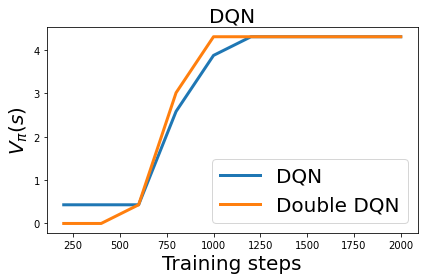

In [63]:
eval_rew_arr_double = np.stack(eval_rew_list_double)
eval_rew_arr = np.stack(eval_rew_list)

eval_rew_mean = np.mean(eval_rew_arr, axis=0)
eval_rew_std = np.std(eval_rew_arr, axis=0)
eval_rew_mean_double = np.mean(eval_rew_arr_double, axis=0)
eval_rew_std_double = np.std(eval_rew_arr_double, axis=0)

plt.Figure(figsize=(20, 16))
fontsize = 20
x = (np.arange(len(eval_rew_mean)) + 1) * steps_per_epoch * 10
plt.plot(x, eval_rew_mean, linewidth=3, label="DQN")
plt.plot(x, eval_rew_mean_double, linewidth=3, label="Double DQN")
plt.xlabel("Training steps", fontsize=fontsize)
plt.ylabel("$V_{\pi}(s)$", fontsize=fontsize)
plt.title("DQN", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig("hw2.png", dpi=300)
# plt.fill_between(x, eval_rew_mean-eval_rew_std, eval_rew_mean + eval_rew_std, alpha=0.3)
# print(eval_rew_arr.shape)
# print(eval_rew_arr)

In [16]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = self.fc2(x)
        action_probs = self.softmax(x)
        return action_probs


class REINFORCEAgent:
    def __init__(self, state_size, action_size, hidden_size, 
                 learning_rate, gamma, train_rollout, device, 
                 baseline_value=None, use_baselines=False):
        self.policy_network = PolicyNetwork(state_size, action_size, hidden_size).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.use_baselines = use_baselines
        self.baseline_value = baseline_value
        self.train_rollout =train_rollout
        self.saved_log_probs = [[] for _ in range(train_rollout)]
        self.rewards = [[] for _ in range(train_rollout)]

    def select_action(self, state, traj_idx=0):
        state = torch.from_numpy(state).float().unsqueeze(0)
        action_probs = self.policy_network(state)
        m = Categorical(action_probs)
        action = m.sample()
        self.saved_log_probs[traj_idx].append(m.log_prob(action))
        return action.item()
    
    def eval_action(self, state):
        self.policy_network.eval()
        state = torch.from_numpy(state).float().unsqueeze(0)
        action_probs = self.policy_network(state)
        action = torch.max(action_probs, dim=1)[1].numpy().squeeze()
        self.policy_network.train()
        return action

    def update_policy(self):
        # R = 0
        policy_loss = []
        gradients = []
        for saved_log_probs, rewards in zip(self.saved_log_probs, self.rewards):
            returns = []; R = 0; gradient = 0
            for r in rewards[::-1]:
                R = r + self.gamma * R
                returns.insert(0, R)
            returns = torch.tensor(returns)
            for log_prob, R in zip(saved_log_probs, returns):
                if self.use_baselines:
                    with torch.no_grad():
                        adjusted_return = R - torch.tensor(self.baseline_value)
                else:
                    adjusted_return = R
                policy_loss.append(-log_prob * adjusted_return)
                grad = torch.autograd.grad(-log_prob * adjusted_return,
                                            self.policy_network.parameters(), 
                                            retain_graph=True)
                gradient += torch.sum(torch.stack([torch.sum(g) for g in grad])).numpy()
            gradients.append(gradient)

        self.optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).mean()
        policy_loss.backward()
        self.optimizer.step()
        self.saved_log_probs = [[] for _ in range(self.train_rollout)]
        self.rewards = [[] for _ in range(self.train_rollout)]
        return np.std(gradients)

In [19]:
epochs = 200
eval_every = 20
train_rollout = 10
eval_rollout = 10
max_len = 100

state_size = 2
action_size = 4
hidden_size = 256
learning_rate = 1e-3

gamma = 0.9
device = "cpu"
seeds = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]

grad_vars_list_reinforce = []
eval_rew_list_reinforce = []
for seed in seeds:
    random.seed(seed)
    torch.manual_seed(seed)

    agent = REINFORCEAgent(state_size, action_size, hidden_size,
                        learning_rate, gamma, train_rollout, device)
    env = GridWorldEnv()
    eval_rew = []
    grad_vars_reinforce = []

    for i in range(epochs):
        # collect data
        for traj_idx in range(train_rollout):
            state = env.reset()
            epi_len = 0
            while True:
                action = agent.select_action(state, traj_idx)
                next_state, reward, done, _ = env.step(action)
                agent.rewards[traj_idx].append(reward)
                state = next_state
                epi_len += 1
                if done or epi_len == max_len:
                    break
                
        grad_var = agent.update_policy()
        grad_vars_reinforce.append(grad_var)
        
        if (i + 1) % eval_every == 0:
            scores = []
            for n in range(eval_rollout):
                state = env.reset()
                score = []
                for t in range(max_len):
                    action = agent.eval_action(state)
                    next_state, reward, done, _ = env.step(action)
                    score.append(reward)
                    state = next_state
                    if done:
                        break
                score = discounted_cumsum(np.array(score), gamma)[0]
                scores.append(score)
            print(f"Epoch {i+1}\tAverage Score: {np.mean(scores)}\tgrad_var = {grad_var}")
            eval_rew.append(np.mean(scores))
    eval_rew_list_reinforce.append(np.array(eval_rew))
    grad_vars_list_reinforce.append(np.array(grad_vars_reinforce))

Epoch 20	Average Score: 0.0	grad_var = 33.96662535540421
Epoch 40	Average Score: 4.3046720999999994	grad_var = 29.74676711398581
Epoch 60	Average Score: 4.3046720999999994	grad_var = 37.43082218544904
Epoch 80	Average Score: 0.0	grad_var = 48.08554287195057
Epoch 100	Average Score: 0.0	grad_var = 18.182605203230807
Epoch 120	Average Score: 4.3046720999999994	grad_var = 35.59603093786085
Epoch 140	Average Score: 0.0	grad_var = 53.6473487626558
Epoch 160	Average Score: 4.3046720999999994	grad_var = 75.32263351484488
Epoch 180	Average Score: 0.0	grad_var = 49.91949830765054
Epoch 200	Average Score: 4.3046720999999994	grad_var = 55.52763527412569
Epoch 20	Average Score: 4.3046720999999994	grad_var = 33.9157915200229
Epoch 40	Average Score: 4.3046720999999994	grad_var = 28.529852076110508
Epoch 60	Average Score: 0.0	grad_var = 48.07303180318084
Epoch 80	Average Score: 4.3046720999999994	grad_var = 28.48256396598354
Epoch 100	Average Score: 4.3046720999999994	grad_var = 40.5036400573777
Epoc

In [20]:

epochs = 200
eval_every = 20
train_rollout = 10
eval_rollout = 10
max_len = 100

state_size = 2
action_size = 4
hidden_size = 256
learning_rate = 1e-3

gamma = 0.9
device = "cpu"
seeds = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180]

eval_rew_list_reinforce_baseline = []
grad_vars_list_reinforce_baseline = []
for seed in seeds:
    random.seed(seed)
    torch.manual_seed(seed)

    agent = REINFORCEAgent(state_size, action_size, hidden_size,
                        learning_rate, gamma, train_rollout, device,
                        baseline_value=4.3046721, use_baselines=True)
    env = GridWorldEnv()
    eval_rew = []
    grad_vars_reinforce_baseline = []

    for i in range(epochs):
        # collect data
        for traj_idx in range(train_rollout):
            state = env.reset()
            epi_len = 0
            while True:
                action = agent.select_action(state, traj_idx)
                next_state, reward, done, _ = env.step(action)
                agent.rewards[traj_idx].append(reward)
                state = next_state
                epi_len += 1
                if done or epi_len == max_len:
                    break
                
        grad_var = agent.update_policy()
        grad_vars_reinforce_baseline.append(grad_var)
        
        if (i + 1) % eval_every == 0:
            scores = []
            for n in range(eval_rollout):
                state = env.reset()
                score = []
                for t in range(max_len):
                    action = agent.eval_action(state)
                    next_state, reward, done, _ = env.step(action)
                    score.append(reward)
                    state = next_state
                    if done:
                        break
                score = discounted_cumsum(np.array(score), gamma)[0]
                scores.append(score)
            print(f"Epoch {i+1}\tAverage Score: {np.mean(scores)}\tgrad_var = {grad_var}")
            eval_rew.append(np.mean(scores))
    eval_rew_list_reinforce_baseline.append(np.array(eval_rew))
    grad_vars_list_reinforce_baseline.append(np.array(grad_vars_reinforce_baseline))

Epoch 20	Average Score: 0.0	grad_var = 46.66515126573355
Epoch 40	Average Score: 0.0	grad_var = 26.513366714157357
Epoch 60	Average Score: 4.3046720999999994	grad_var = 40.483480197209204
Epoch 80	Average Score: 4.3046720999999994	grad_var = 34.62626746605819
Epoch 100	Average Score: 4.3046720999999994	grad_var = 28.47786637808711
Epoch 120	Average Score: 4.3046720999999994	grad_var = 17.82886890809541
Epoch 140	Average Score: 4.3046720999999994	grad_var = 27.2659939921839
Epoch 160	Average Score: 4.3046720999999994	grad_var = 29.795515143586655
Epoch 180	Average Score: 4.3046720999999994	grad_var = 21.995855259476034
Epoch 200	Average Score: 4.3046720999999994	grad_var = 19.712321698640746
Epoch 20	Average Score: 0.0	grad_var = 34.97940948093778
Epoch 40	Average Score: 0.0	grad_var = 28.694934294968547
Epoch 60	Average Score: 4.3046720999999994	grad_var = 4.556607927852315
Epoch 80	Average Score: 4.3046720999999994	grad_var = 20.052818212929935
Epoch 100	Average Score: 4.3046720999999

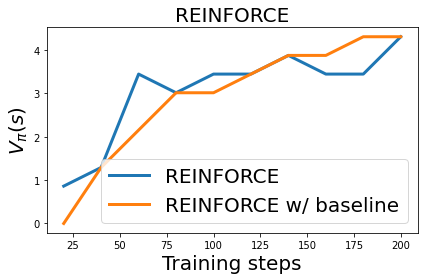

In [21]:
eval_rew_arr_reinforce = np.stack(eval_rew_list_reinforce)
eval_rew_arr_reinforce_baseline = np.stack(eval_rew_list_reinforce_baseline)

eval_rew_mean_reinforce = np.mean(eval_rew_arr_reinforce, axis=0)
eval_rew_std_reinforce = np.std(eval_rew_arr_reinforce, axis=0)
eval_rew_mean_reinforce_baseline = np.mean(eval_rew_arr_reinforce_baseline, axis=0)
eval_rew_std_reinforce_baseline = np.std(eval_rew_arr_reinforce_baseline, axis=0)

plt.Figure(figsize=(20, 16))
fontsize = 20
x = (np.arange(len(eval_rew_mean_reinforce)) + 1) * eval_every
plt.plot(x, eval_rew_mean_reinforce, linewidth=3, label="REINFORCE")
plt.plot(x, eval_rew_mean_reinforce_baseline, linewidth=3, label="REINFORCE w/ baseline")
plt.xlabel("Training steps", fontsize=fontsize)
plt.ylabel("$V_{\pi}(s)$", fontsize=fontsize)
plt.title("REINFORCE", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig("hw2-reinforce.png", dpi=300)

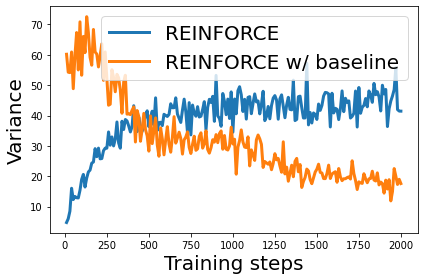

In [26]:
grad_vars_arr_reinforce = np.stack(grad_vars_list_reinforce)
grad_vars_arr_reinforce_baseline = np.stack(grad_vars_list_reinforce_baseline)

grad_vars_mean_reinforce = np.mean(grad_vars_arr_reinforce, axis=0)
grad_vars_mean_reinforce_baseline = np.mean(grad_vars_arr_reinforce_baseline, axis=0)

plt.Figure(figsize=(20, 16))
fontsize = 20
x = (np.arange(len(grad_vars_mean_reinforce)) + 1) * train_rollout
plt.plot(x, grad_vars_mean_reinforce, linewidth=3, label="REINFORCE")
plt.plot(x, grad_vars_mean_reinforce_baseline, linewidth=3, label="REINFORCE w/ baseline")
plt.xlabel("Training steps", fontsize=fontsize)
plt.ylabel("Variance", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig("hw2-variance.png", dpi=300)
